In [1]:
#include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, QuadGK, SpecialFunctions, TwoFAST, LaTeXStrings

In [3]:
#=
FILE_F_MAP = "../data/F_REFERENCE.txt"
#FILE_PS = "../data/WideA_ZA_pk.dat"
FILE_PS = "file_pk.txt"
FILE_BACKGROUND = "../data/WideA_ZA_background.dat"
#FILE_IS = "tab_xi.txt"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 1000.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70)
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP)#, FILE_IS)

GaPSE.parameters_used(stdout, cosmo)
=#

In [15]:
tab_CLASS_pk = readdlm("../data/WideA_ZA_pk.dat", comments=true);
CLASS_ks = convert(Vector{Float64}, tab_CLASS_pk[:,1]);
CLASS_k_min, CLASS_k_max = CLASS_ks[begin], CLASS_ks[end]
CLASS_pks = convert(Vector{Float64}, tab_CLASS_pk[:,2]);
CLASS_spline = Spline1D(CLASS_ks, CLASS_pks);

In [16]:
tab_casto_pk = readdlm("file_pk.txt")
casto_ks = tab_casto_pk[:,1]
casto_k_min, casto_k_max = casto_ks[begin], casto_ks[end]
casto_pks = tab_casto_pk[:,2]
casto_spline = Spline1D(casto_ks, casto_pks);

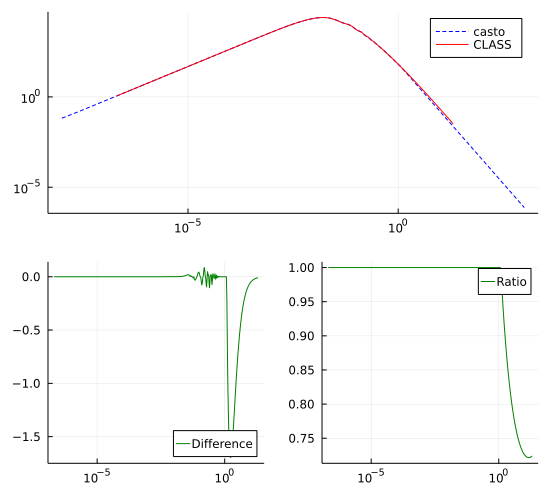

In [17]:
spline = casto_spline

p1 = plot([casto_ks, CLASS_ks] , 
    [casto_pks, CLASS_pks],
    xaxis=:log, yaxis=:log,
    lc=[:blue :red], ls=[:dash :solid], labels=["casto" "CLASS"])

p2 = plot(CLASS_ks, spline.(CLASS_ks) .- CLASS_pks, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(CLASS_ks, spline.(CLASS_ks) ./ CLASS_pks, xaxis=:log, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(550, 500), layout= @layout [ x ; y z ] )

In [132]:
?next

search: nextpow nextind nextprod nextfloat InexactError IndexStyle IOContext

Couldn't find next
Perhaps you meant text, Text, new, hex, Set, exit, exp, get, let or nextind


No documentation found.

Binding `next` does not exist.


In [154]:
function derivate_point(xp, yp, x1, y1, x2, y2)
    m2 = (y2 - yp)/(x2 - xp)
    m1 = (yp - y1)/(xp - x1)
    res = (m1 + m2)/2.0
    #println(res)
    return res
end

function derivate_vector(xs, ys; N::Integer = 1)
    if N == 1
        real_vec = [derivate_point(xs[i], ys[i], xs[i-1], ys[i-1], xs[i+1], ys[i+1]) 
                for i in (N+1):(length(xs)-N)]
        return vcat(real_vec[begin], real_vec, real_vec[end])
    elseif N>1
        vec = [ derivate_point(xs[i], ys[i], xs[i-j], ys[i-j], xs[i+j], ys[i+j]) 
        for i in (N+1):(length(xs)-N), j in 1:N]
        real_vec = [sum(row)/N for row in eachrow(vec)]
        return vcat([real_vec[begin] for i in 1:N], real_vec,
            [real_vec[end] for i in 1:N] )
    else 
        throw(ErrorException(" N must be an integer >1, not $N!"))
    end
end

function spectral_index(xs, ys; N::Integer=1, con=false)
    derivs = derivate_vector(xs, ys; N=N)
    if con == false
        return [x*d/y for (x,y,d) in zip(xs, ys, derivs)]
    else
        sec_derivs = derivate_vector(xs, derivs; N=N)
        vec = [x*d2/d for (x,d,d2) in zip(xs, derivs, sec_derivs)]
        return vec .+ 1.0 
    end
end
#=

function power_law_a_b(x1, y1, x2, y2, si)
    b = (y2 - y1)/(x2^si - x1^si)
    a = y1 - b*(x1^si)
    return a,b
end

function power_law_a_b(xs, ys, sis)
    bs = [power_law_b(xs[i], ys[i], xs[i+1], ys[i+1], sis[i]) for i in 1:length(xs)-1]
    as = [y - b*(x^si) for (x,y,b,si) in zip(xs, ys, bs, sis)]
    return vcat(bs, bs[end]), vcat(as, as[end])
end
=#

power_law_b(x1, y1, x2, y2, si) = (y2 - y1)/(x2^si - x1^si)
function power_law_b(xs, ys, sis)
    bs = [power_law_b(xs[i], ys[i], xs[i+1], ys[i+1], sis[i]) for i in 1:length(xs)-1]
    return vcat(bs, bs[end])
end

power_law_a(x, y, b, si) = y - b*(x^si)

power_law(x, si, b, a=0.0) = a + b *(x^si)

power_law (generic function with 2 methods)

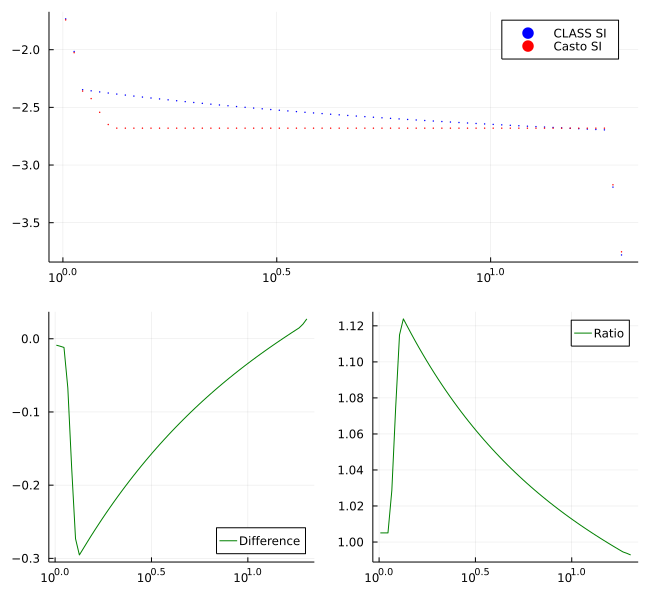

In [120]:
x_min = 1e0
x_max = 1e2

xs = CLASS_ks[x_min.< CLASS_ks .< x_max]
first_ys = CLASS_pks[x_min.< CLASS_ks .< x_max]
sec_ys = casto_spline.(xs)

first_sis = spectral_index(xs, first_ys; N=2, con=false)
sec_sis = spectral_index(xs, sec_ys; N=2, con=false)


p1 = scatter( [xs, xs], [first_sis, sec_sis] ,
    xscale=:log10, #yscale=:log10,
    label=["CLASS SI" "Casto SI"], color=[:blue :red], 
    markersize = [1 1], markerstrokewidth=[0 0] )

p2 = plot(xs, sec_sis .- first_sis, 
    xscale=:log10,
    label="Difference", lc=:green, legend=:bottomright)

p3 = plot(xs, sec_sis ./ first_sis, xscale=:log10, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

In [147]:
N = 2
#si_begin, si_end = CLASS_sis[begin], CLASS_sis[end];
casto_sis = spectral_index(casto_ks, casto_pks; N=N, con=true)
CLASS_sis = spectral_index(CLASS_ks, CLASS_pks; N=N, con=true)

421-element Vector{Float64}:
  0.9824059475237246
  0.9815767653761859
  0.9807085050779634
  0.9652284351337773
  0.9599801560473472
  0.9599801505448017
  0.959980145275018
  0.9599801426033746
  0.9599801437337805
  0.9599801434059464
  0.9599801396325511
  0.959980134942407
  0.9599801309193737
  ⋮
 -2.666149764136334
 -2.670419703231114
 -2.6746199693367454
 -2.678753647299741
 -2.682822708238832
 -2.686827579322452
 -2.6907713282146815
 -2.6946556134036133
 -2.360041677369541
 -1.1441431309413859
 -1.245193483515497
 -1.351006192487341

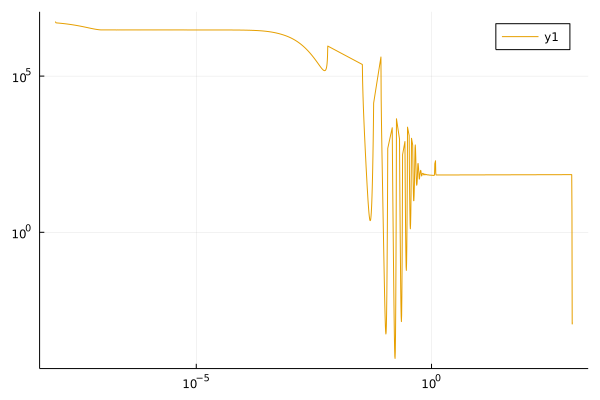

In [153]:
bs = power_law_b(casto_ks, casto_pks, casto_sis )
plot(casto_ks[bs .>0 ], bs[bs .>0 ], xaxis=:log, yaxis=:log)

In [155]:
function power_law_from_data(xs, ys, x1, x2; N=3, con=false)
    @assert length(xs) == length(ys) "xs and ys must have same length"
    Num = length(xs)
    
    sis = spectral_index(xs[x1 .< xs .< x2], ys[x1 .< xs .< x2]; 
                N = N, con = con)
    bs = power_law_b(xs[x1 .< xs .< x2], ys[x1 .< xs .< x2], sis)
    
    as = con ? power_law_a.(xs, ys, bs, sis) : [0.0 for i in 1:length(xs)]
    
    r = N+1
    a = sum(as[begin+r:end-r])/ (Num - 2*r)
    b = sum(bs[begin+r:end-r])/ (Num - 2*r)
    si = sum(sis[begin+r:end-r])/ (Num - 2*r)
    return si, b, a
end

power_law_from_data (generic function with 1 method)

In [ ]:
function spline_IPS(ks, pks; N = 3, con=false)
    k1, k2 = 1e-6, 1e-4
    k3, k4 = 1e1, 2e1
    
    si_beg, b_beg, a_beg = power_law_from_data(ks, pks, k1, k2; N=N, con=con)
    si_end, b_end, a_end = power_law_from_data(ks, pks, k3, k4; N=N, con=con)
    
    l_beg, l_end = ks[begin+1] - ks[begin] , ks[end] - ks[end-1] 
    c_beg, c_end = ks[begin+1] / ks[begin] , ks[end] / ks[end-1]
    
    
end

In [128]:
CLASS_si_of_sis = spectral_index(CLASS_ks[begin+N:end-N], CLASS_sis; 
                        N=N)[begin+N:end-N]
new_CLASS_ks = CLASS_ks[(begin +2*N):(end - 2*N)];

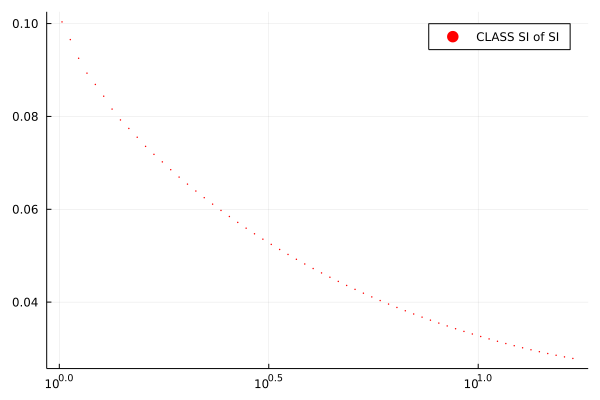

In [45]:
x_min = 1e0
x_max = 1e3

scatter(new_CLASS_ks[x_min.< new_CLASS_ks .< x_max], 
        CLASS_si_of_sis[x_min.< new_CLASS_ks .< x_max], 
    xscale=:log10, #yscale=:log10,
    label="CLASS SI of SI", color=:red, 
    markersize = 1, markerstrokewidth=0)